# Libraries

In [1]:
# project_path = 'put_your_project_path_here'
project_path = '../../'

In [2]:
import sys
sys.path.insert(1, project_path)   # caution: path[0] is reserved for script path (or '' in REPL)

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_RBF_eval
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Loading Dataset

In [3]:
X, y, ID = data_loader.load_dataset(X_path='../../data/2023-11-08/feature_mfcc_34_delta_delta_nfft_4096.csv', 
                                    y_path='../../data/2023-11-08/y_labels_feature_34_mfcc_delta_delta_nfft_4096.csv',
                                    ID_path='../../data/2023-11-08/IDs_feature_mfcc_34_delta_delta_nfft_4096.csv') 

data loaded in 0.09301996231079102ms
          0         1         2         3         4         5         6  \
0  0.327805 -0.464719 -0.540320 -0.983787 -1.276392 -0.517576 -0.059207   
1 -0.483202 -0.287426  0.073267 -0.259939 -1.043461  0.220426 -0.243781   
2 -0.982079  1.092156 -0.237941 -0.002997 -0.934974  0.313563  0.708375   
3  0.968642 -1.604765 -0.123183 -0.789169 -1.783557 -0.222486 -0.352760   
4  0.548607 -1.485735 -0.842989 -0.959707 -1.563772 -0.373401 -0.273213   

          7         8         9  ...       296       297       298       299  \
0 -1.325718 -0.865250 -1.400271  ... -0.000500  0.245232  0.467592  0.179897   
1 -0.745799 -0.558315 -0.667095  ...  0.081401 -0.156604  0.054227  1.335473   
2  0.392641 -0.112142 -0.675854  ...  1.159202 -0.281807  0.370446  0.969862   
3 -1.354752 -0.871037 -0.944073  ... -0.582348  1.606737 -1.213523  0.283672   
4 -1.374351 -0.530736 -0.333489  ... -0.312877 -1.016252 -0.713702  0.537837   

        300       301       302

# Backward step selection

In [4]:
def back_step_selection_svm_rbf(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_RBF_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind).astype(np.double)
      for i in range(len(feature_ind)):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu,_,_,_,_ = SVM_RBF_eval(X,y,cur_inds, ID)                  
         
         if (acc_mu>=acc_mu_curr):
            acc_up[i] = acc_mu-acc_mu_curr
            print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
            
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr,_,_,y_pred,y_true = SVM_RBF_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind,y_pred,y_true

## Full cycle of feature selection

In [8]:
emotions = ['happy', 'neutral', 'sad', 'calm', 'fear', 'disgust', 'surprised', 'angry']

for emotion_label in emotions:
    # Relabeling and normilizing
    y_true = np.zeros((len(y)))
    y_true[np.squeeze(y.values==emotion_label)] = 1
    y_true[y_true==0] = -1

    X_data = X.values
    X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
    y_reg = copy.copy(y_true)

    try:
        Rank = np.load(f'../../data/svm/Lasso_Ranking_SVM_rbf_{emotion_label}_result.npy')
    except:
        print("We need to compute LASSO ranking")

        # LASSO ranking
        Lasso_model = linear_model.Lasso()
        Npt = 200
        coeffs = np.zeros((X_norm.shape[1],Npt))
        lambda_ = np.logspace(-12.5, 0.3, Npt)
        i = 0
        for lamb in tqdm(lambda_):
            Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
            Lasso_model.fit(X_norm,y_reg)
            coeffs[:,i] = Lasso_model.coef_
            i = i + 1

        plt.figure(dpi=110)
        plt.plot(coeffs.T)
        plt.xlabel('$\lambda$ number')
        plt.ylabel('Coeffs')
        plt.show()    

        Rank_lasso = []
        for i in range(coeffs.shape[1]-1,-1,-1):
            withdraw_features = np.nonzero(coeffs[:,i])[0];
            something_new = np.setdiff1d(withdraw_features, Rank_lasso)
            if len(something_new):
                for ii in range(len(something_new)):
                    Rank_lasso.append(something_new[ii])
    
        np.save(f'../../data/svm/Lasso_Ranking_SVM_rbf_{emotion_label}_result.npy', Rank_lasso)    # .npy extension is added if not given
        Rank = np.load(f'../../data/svm/Lasso_Ranking_SVM_rbf_{emotion_label}_result.npy')

    # LOSO accuracy estimation
    try:
        auc_svm = np.load(f'../../data/svm/feature_SVM_rbf_uar_total_{emotion_label}.npy')       
    except:
        print("We need to compute effective number of features")        
        auc_svm = []
        auc_best = 0
        ind_best = 0
        for k in tqdm(range(1,len(Rank)+1)):
            feature_inds = Rank[:k]
            auc,_,_,_,_ = SVM_RBF_eval(X,pd.DataFrame(y_reg), feature_inds, ID)    
            auc_svm.append(auc)
            if (auc>auc_best):
                auc_best = auc
                ind_best = k-1
                print('Iter = ', k, f' UAR = {auc:.4f}' )
        
        fig,ax=plt.subplots(figsize=(7,4),dpi=100)
        plt.rcParams.update({'font.size': 14})
        plt.plot(auc_svm,marker='o', linestyle='dashed')
        plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
        plt.xlabel('Number of features')
        plt.ylabel('Accuracy')
        plt.title('SVM classifier')
        plt.ylim([0.45, 1.00])
        plt.show()
        
        print(f'auc_best = {auc_best:.8f}')
        print('best auc (SVM) = ', np.max(auc_svm), 'Number of features = ', np.argmax(auc_svm))

        np.save(f'../../data/svm/feature_SVM_rbf_uar_total_{emotion_label}.npy', auc_svm)    # .npy extension is added if not given
        auc_svm = np.load(f'../../data/svm/feature_SVM_rbf_uar_total_{emotion_label}.npy')
        
    try:        
        feature_ind = np.load(f'../../data/svm/feature_SVM_rbf_idx_{emotion_label}.npy')
    except:
        # Backward step selection
        ind_best = np.argmax(auc_svm)
        [acc_final, feature_ind, y_pred, y_true] = back_step_selection_svm_rbf(X, y, Rank[:ind_best+1], ID)
        np.save(f'../../data/svm/feature_SVM_rbf_idx_{emotion_label}.npy', feature_ind)    # .npy extension is added if not given
        feature_ind = np.load(f'../../data/svm/feature_SVM_rbf_idx_{emotion_label}.npy')
    
    # Results of 5-fold CV (selected feature space)
    plotting_utils.plot_confusion_matrix_eng(y_true, y_pred,image_path=f'../../data/svm/confusion_matrix_SVM_rbf_{emotion_label}.jpg')


NameError: name 'Rank' is not defined

# 5-fold CV (full feature space)

In [6]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

C = 0.100000, gamma = 0.000316
C = 0.100000, gamma = 0.000527
C = 0.100000, gamma = 0.000880
C = 0.100000, gamma = 0.001468
C = 0.100000, gamma = 0.002448
C = 0.100000, gamma = 0.004084
C = 0.187382, gamma = 0.001468
C = 0.187382, gamma = 0.002448
C = 0.351119, gamma = 0.001468
C = 0.351119, gamma = 0.002448
C = 0.657933, gamma = 0.001468
C = 0.657933, gamma = 0.002448
C = 0.657933, gamma = 0.004084
C = 1.232847, gamma = 0.001468
C = 1.232847, gamma = 0.002448
C = 1.232847, gamma = 0.004084
C = 2.310130, gamma = 0.001468


ValueError: x and y must have same first dimension, but have shapes (12,) and (120,)

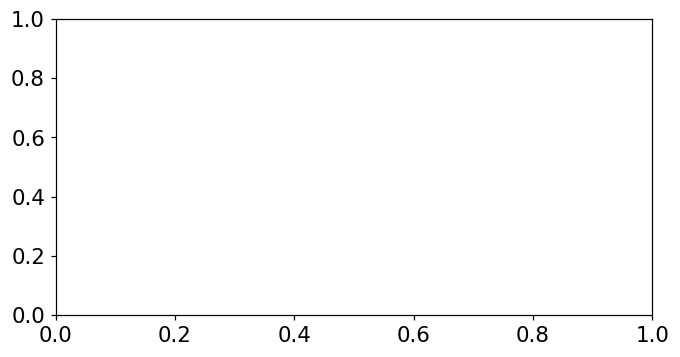

In [7]:
C = np.logspace(-1, 2, 12, endpoint=True)
gamma = np.logspace(-3.5, -1.5, 10, endpoint=True)

UAR_list = []
UAR_best = 0
for val_C in C:
    for val_gamma in gamma:
        model = SVC(kernel = 'rbf', C=val_C, gamma=val_gamma, random_state = 42)
        UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
        if UAR_best < UAR:
            UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
            C_best = val_C
            gamma_best = val_gamma
            print(f'UAR = {UAR_best:.3f}, C = {val_C:.6f}, gamma = {val_gamma:.6f}')
        UAR_list.append(UAR)
    
# fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# # plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
# # plt.ylim([0.37, 0.48])
# # plt.xlabel('$\log_{10}(C)$')
# plt.xlabel('$C$')
# plt.ylabel('UAR')
# plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
# plt.title('SVM with RBF kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')    

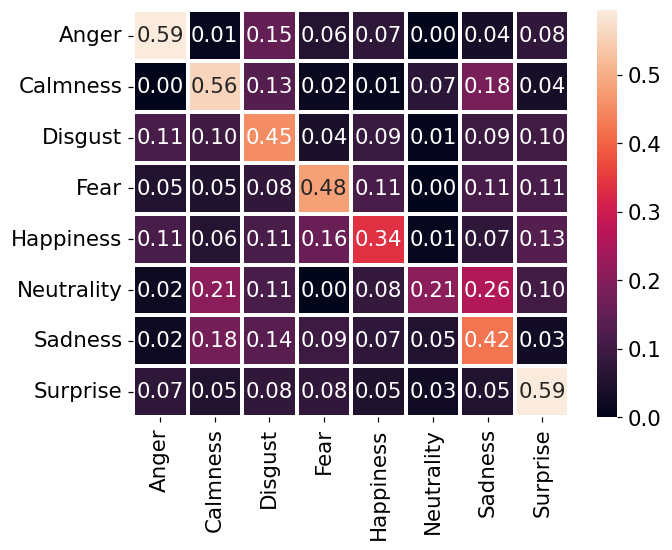

Saving confusion matrix with name:  confusion_matrix_SVM_full.jpg


In [14]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred,image_path=f'confusion_matrix_SVM_full.jpg')

# Joint subset of features

In [15]:
emotions = ['happy', 'neutral', 'sad', 'calm', 'fear', 'disgust', 'surprised', 'angry']
feature_joint_inds = []

for emotion_label in emotions:
    feature_ind = np.load(f'../../data/svm/feature_SVM_idx_{emotion_label}.npy')
    feature_joint_inds = np.unique(np.concatenate((feature_joint_inds, feature_ind)))

feature_joint_inds = feature_joint_inds.astype(int)

In [16]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_joint_inds])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

In [21]:
X_new.shape

(1440, 208)

In [19]:
C = np.logspace(-1, 2, 12, endpoint=True)
gamma = np.logspace(-3.5, -1.5, 10, endpoint=True)

UAR_list = []
UAR_best = 0
for val_C in C:
    for val_gamma in gamma:
        model = SVC(kernel = 'rbf', C=val_C, gamma=val_gamma, random_state = 42)
        UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
        if UAR_best < UAR:
            UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
            C_best = val_C
            gamma_best = val_gamma
            print(f'C = {val_C:.6f}, gamma = {val_gamma:.6f}')
        UAR_list.append(UAR)
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}, gamma_best = {gamma_best: .3f}')        

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.86it/s]

UAR = 0.410


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 10.81it/s]

UAR = 0.425


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.21it/s]

UAR = 0.434


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.86it/s]

UAR = 0.447


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.21it/s]

UAR = 0.466


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.43it/s]

UAR = 0.473


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.42it/s]

UAR = 0.449


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.02it/s]

UAR = 0.450


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 12.10it/s]

UAR = 0.437


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.94it/s]

UAR = 0.443
UAR_best = 0.473, C_best = 0.008


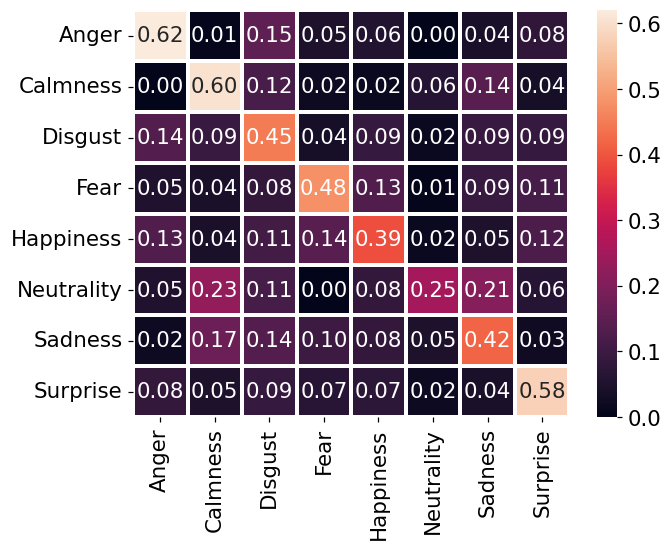

Saving confusion matrix with name:  confusion_matrix_SVM_joint_features.jpg


In [20]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred,image_path=f'confusion_matrix_SVM_joint_features.jpg')